In [172]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns 
import numpy as np 
import pandas as pd 

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL 
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from itertools import cycle, islice
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import math 
import warnings 
import missingno 

warnings.filterwarnings("ignore")
plt.style.use("default")
sns.set(style="whitegrid")

## Challenge: Factors that affect life expectancy

Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

- First, load the dataset.

- Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

- Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

- In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

- Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

In [3]:
kagle = dict(
    drivername="postgresql", 
    username="dsbc_student", 
    password="7*.8G9QH21", 
    host="142.93.121.174", 
    port="5432", 
    database="lifeexpectancy"
)

engine = create_engine(URL(**kagle), echo=True)

life_expectancy_raw = pd.read_sql_query("SELECT * FROM lifeexpectancy", con=engine)

engine.dispose()

2019-12-06 10:09:46,024 INFO sqlalchemy.engine.base.Engine select version()
2019-12-06 10:09:46,026 INFO sqlalchemy.engine.base.Engine {}
2019-12-06 10:09:46,125 INFO sqlalchemy.engine.base.Engine select current_schema()
2019-12-06 10:09:46,128 INFO sqlalchemy.engine.base.Engine {}
2019-12-06 10:09:46,227 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-12-06 10:09:46,229 INFO sqlalchemy.engine.base.Engine {}
2019-12-06 10:09:46,279 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-12-06 10:09:46,281 INFO sqlalchemy.engine.base.Engine {}
2019-12-06 10:09:46,335 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2019-12-06 10:09:46,339 INFO sqlalchemy.engine.base.Engine {}
2019-12-06 10:09:46,439 INFO sqlalchemy.engine.base.Engine SELECT * FROM lifeexpectancy
2019-12-06 10:09:46,441 INFO sqlalchemy.engine.base.Engine {}


In [4]:
life_expectancy_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [5]:
# The column headers are a mess, clean them up and standardize them
# Strip leading and trailing whitespace from the column headers 
life_expectancy_raw.columns = life_expectancy_raw.columns.str.strip()
# Lowercase the column headers
life_expectancy_raw.columns = life_expectancy_raw.columns.str.lower()
# Replace spaces between words with underscores
life_expectancy_raw.columns = life_expectancy_raw.columns.str.replace(" ", "_")

life_expectancy_raw.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness__1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [6]:
# Adjust data types 
# Alter the column types for the "country" and "status" variables
life_expectancy_raw[["country", "status"]] = life_expectancy_raw[["country", "status"]].astype("category")
# Change the "year" variable to datetime
life_expectancy_raw["year"] = pd.to_datetime(life_expectancy_raw["year"], format="%Y")
life_expectancy_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null category
year                               2938 non-null datetime64[ns]
status                             2938 non-null category
life_expectancy                    2928 non-null float64
adult_mortality                    2928 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2744 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2385 non-null float64
measles                            2938 non-null int64
bmi                                2904 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2919 non-null float64
total_expenditure                  2712 non-null float64
diphtheria                         2919 non-null float64
hiv/aids                           

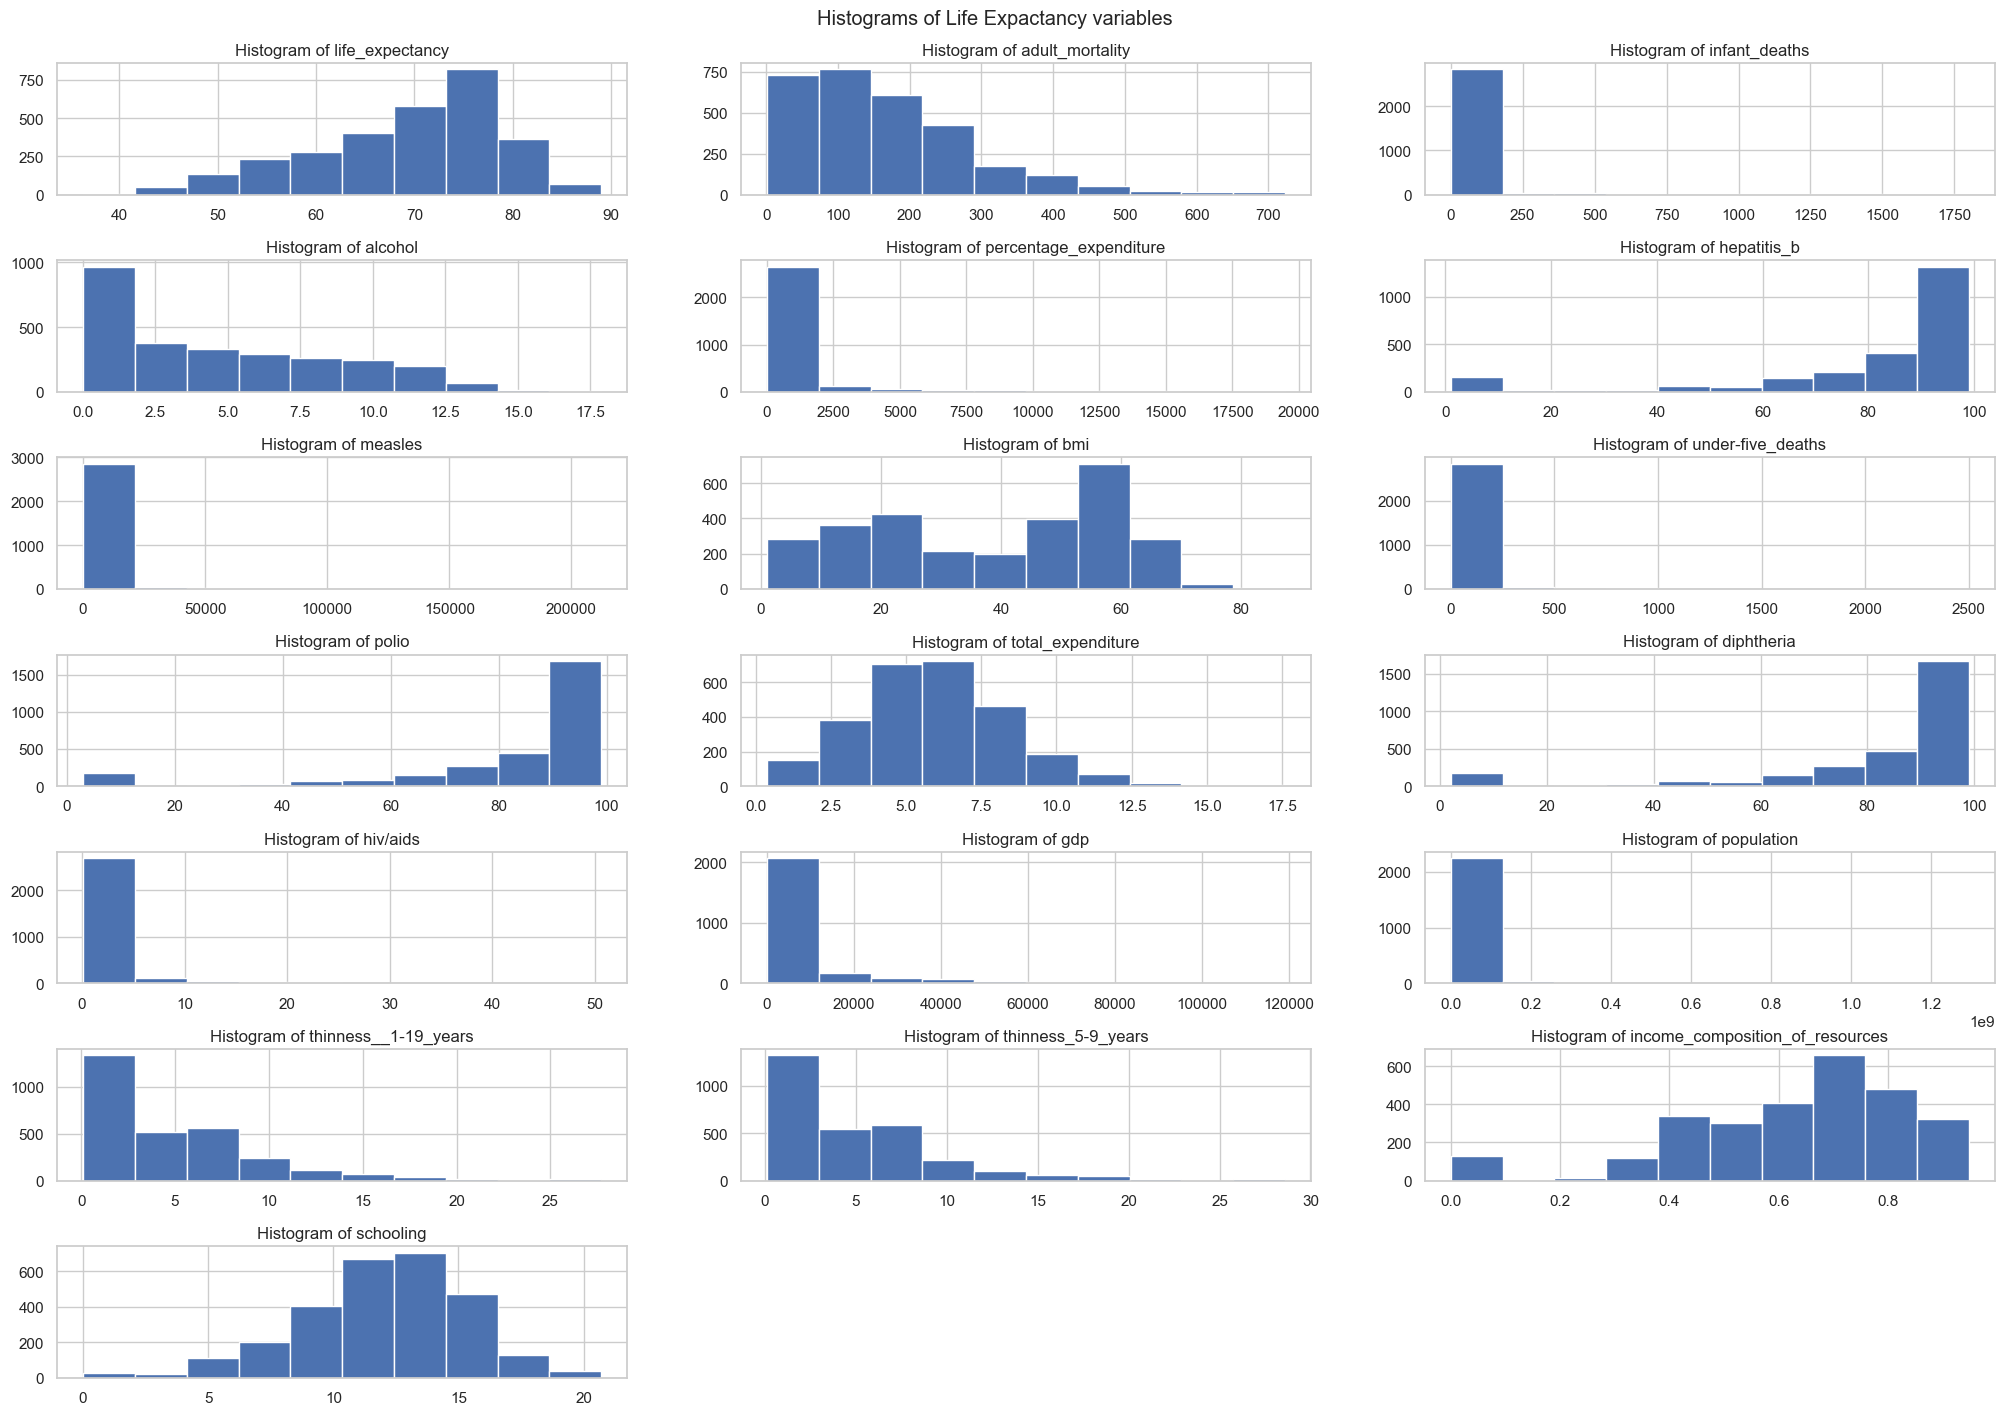

In [7]:
# Take a quick look at the variables the see what kind of distributions you are dealing with
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_raw.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_raw[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [8]:
# Take an initial look at nulls in the data
def null_report(df):
    categorical_cols = df.select_dtypes(include="category").columns
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

    # Create a rowcount variable
    df_len = len(df)

    # Calculated the width of the longest column
    max_col = len(max(df.columns, key=len))

    for col in categorical_cols: 
        # Use sorted function to generate a list of the 5 shortest categories
        short_cats = sorted(set(df[col]), key=len)[:5]
        print(f"First five shortest strings in '{col}': {short_cats}")

    # Look at null value information for continuous variables
    for col in categorical_cols:
        empty_strings = len(df.loc[df[col]==''])
        nulls = df[col].isna().sum()
        tot_nulls = empty_strings + nulls
        pct_nan = tot_nulls*100/df_len
        unique_vals = df[col].nunique()
        print(f"{col:<{max_col}}: {tot_nulls:>{5}} nulls | percent null: {pct_nan:>{5}.2f} | unique values: {unique_vals:>{24},.2f}")

    # Look a null value information for continuous variables
    for col in continuous_cols:
        nulls = df[col].isnull().sum()
        pct_null = nulls*100/df_len
        var = df[col].var()
        print(f"{col:<{max_col}}: {nulls:>{5}} nulls | percent null: {pct_null:>{5}.2f} | col variance: {var:>{25},.2f}")

null_report(life_expectancy_raw)

First five shortest strings in 'country': ['Peru', 'Cuba', 'Iraq', 'Oman', 'Chad']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :    10 nulls | percent null:  0.34 | col variance:                     90.70
adult_mortality                :    10 nulls | percent null:  0.34 | col variance:                 15,448.52
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :   194 nulls | percent null:  6.60 | col variance:                     16.42
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :   553 nulls | percent null: 18.82 | col variance:   

Number of null values: 1289


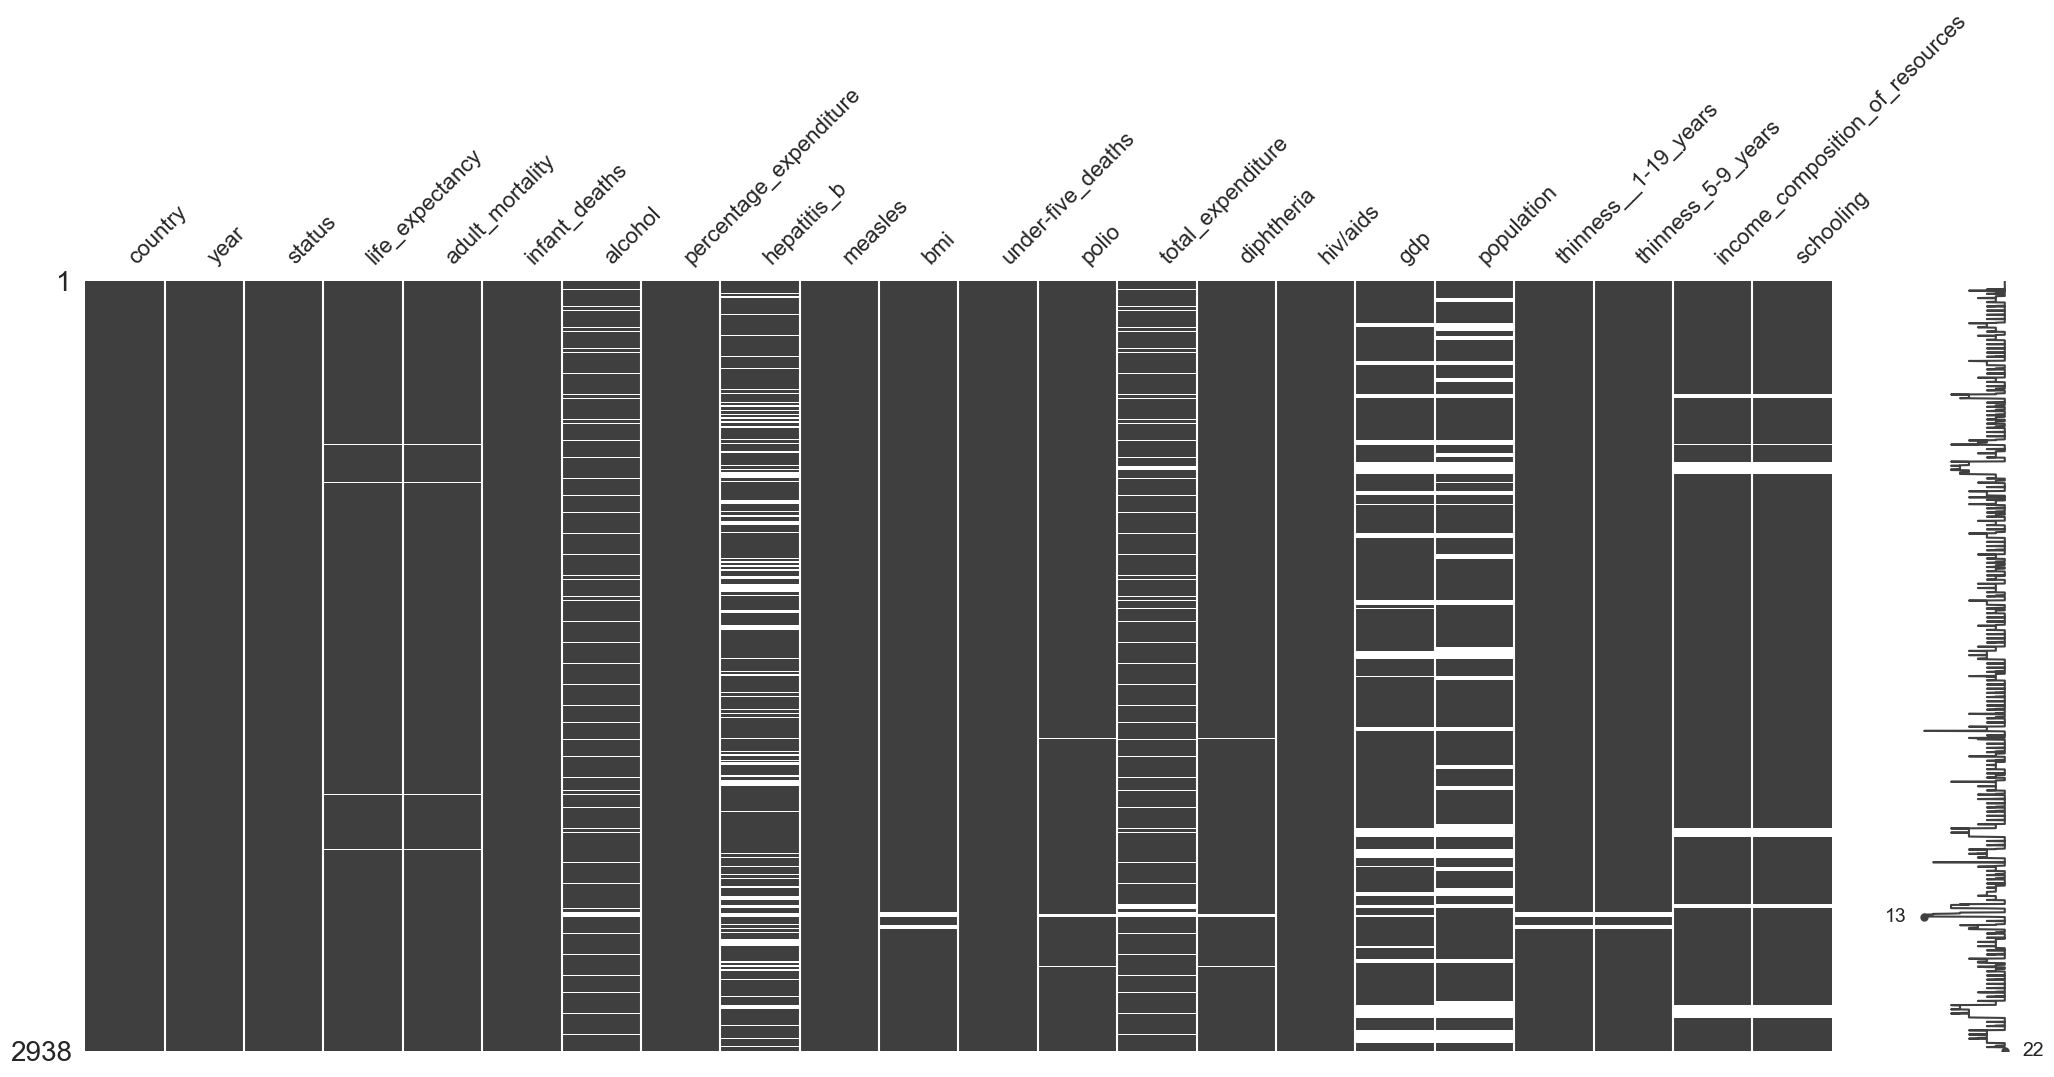

In [9]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")
        missingno.matrix(df)
        plt.show()
    else:
        print("No rows with null values found.")

report_null_entries(life_expectancy_raw)

In [10]:
# Interpolate missing values and drop remaining null values
life_expectancy_interpolated = life_expectancy_raw.copy()

# Try dropping the GDP and Populaion columns to help with null replacement
life_expectancy_interpolated.drop(["gdp","population"], axis=1, inplace=True)

# Get a list of countries to group by 
countries = life_expectancy_interpolated["country"].unique()

continuous_cols = life_expectancy_interpolated.select_dtypes(exclude= \
    ['object','category','datetime64[ns]']).columns

for country in countries: 
    life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]==country, continuous_cols] = \
        life_expectancy_interpolated.loc[life_expectancy_interpolated["country"]== \
            country, continuous_cols].interpolate(limit_direction="both")

# life_expectancy_interpolated.dropna(inplace=True)

null_report(life_expectancy_interpolated)

First five shortest strings in 'country': ['Peru', 'Cuba', 'Iraq', 'Oman', 'Chad']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :    10 nulls | percent null:  0.34 | col variance:                     90.70
adult_mortality                :    10 nulls | percent null:  0.34 | col variance:                 15,448.52
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :    17 nulls | percent null:  0.58 | col variance:                     16.57
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :   144 nulls | percent null:  4.90 | col variance:   

Number of null values: 330


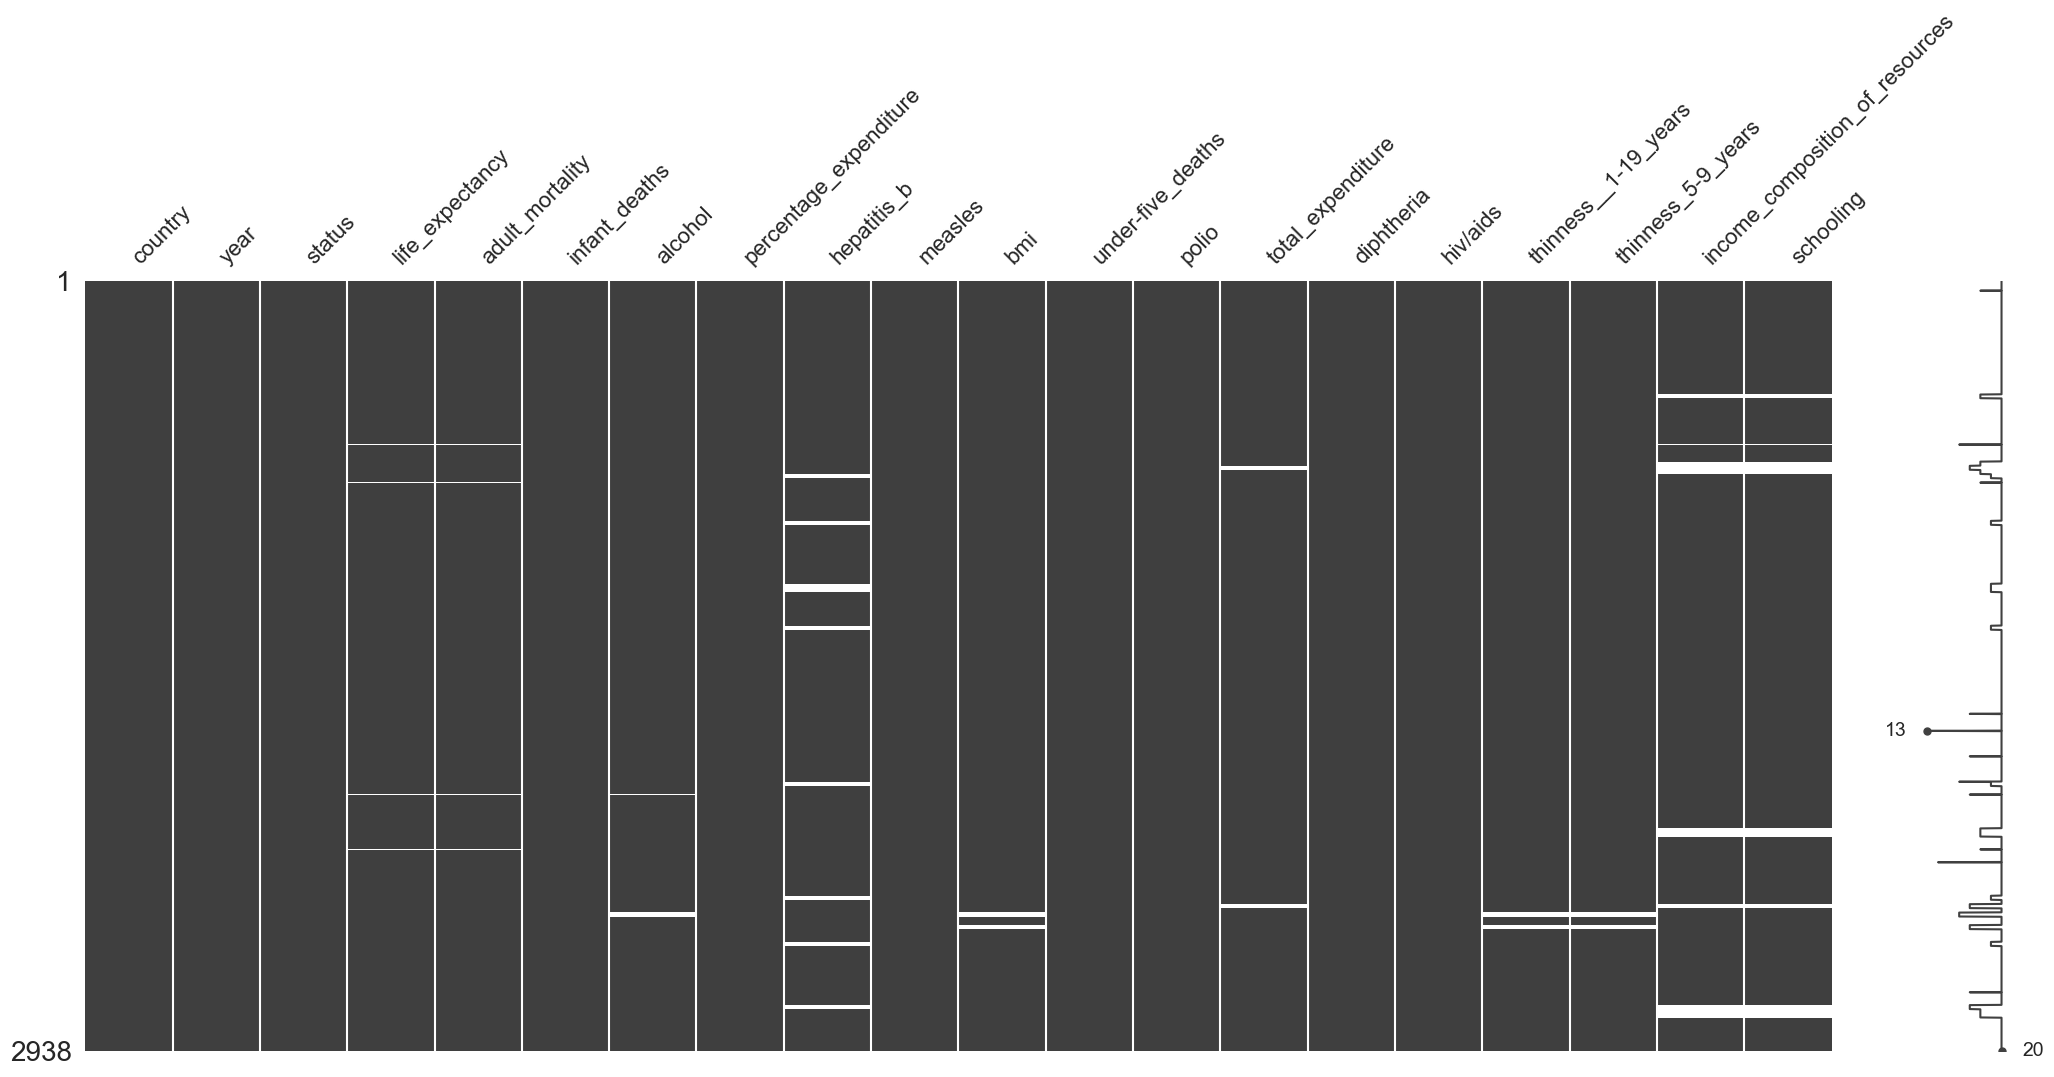

None

In [11]:
display(report_null_entries(life_expectancy_interpolated))



After interpolation there are still null values present in the data.  This is due to grouping the data by country prior to interpolation because there is insufficient data for some countries to interpolate.  I will replace remaining null values with the mean value for each year.

In [12]:
# Get a list of countries to group by 
life_expectancy_df = life_expectancy_interpolated.copy()
continuous_cols = life_expectancy_df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns

for col in continuous_cols: 
    life_expectancy_df[col] = life_expectancy_df.groupby("year")[col]\
        .transform(lambda x: x.fillna(x.mean()))

print("Mean replacement complete.")

display(report_null_entries(life_expectancy_df))

Mean replacement complete.
No rows with null values found.


None

In [15]:
life_expectancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 20 columns):
country                            2938 non-null category
year                               2938 non-null datetime64[ns]
status                             2938 non-null category
life_expectancy                    2938 non-null float64
adult_mortality                    2938 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2938 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2938 non-null float64
measles                            2938 non-null int64
bmi                                2938 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2938 non-null float64
total_expenditure                  2938 non-null float64
diphtheria                         2938 non-null float64
hiv/aids                           

First five shortest strings in 'country': ['Peru', 'Cuba', 'Iraq', 'Oman', 'Chad']
First five shortest strings in 'status': ['Developed', 'Developing']
country                        :     0 nulls | percent null:  0.00 | unique values:                   193.00
status                         :     0 nulls | percent null:  0.00 | unique values:                     2.00
life_expectancy                :     0 nulls | percent null:  0.00 | col variance:                     90.41
adult_mortality                :     0 nulls | percent null:  0.00 | col variance:                 15,396.79
infant_deaths                  :     0 nulls | percent null:  0.00 | col variance:                 13,906.66
alcohol                        :     0 nulls | percent null:  0.00 | col variance:                     16.47
percentage_expenditure         :     0 nulls | percent null:  0.00 | col variance:              3,951,805.48
hepatitis_b                    :     0 nulls | percent null:  0.00 | col variance:   

None

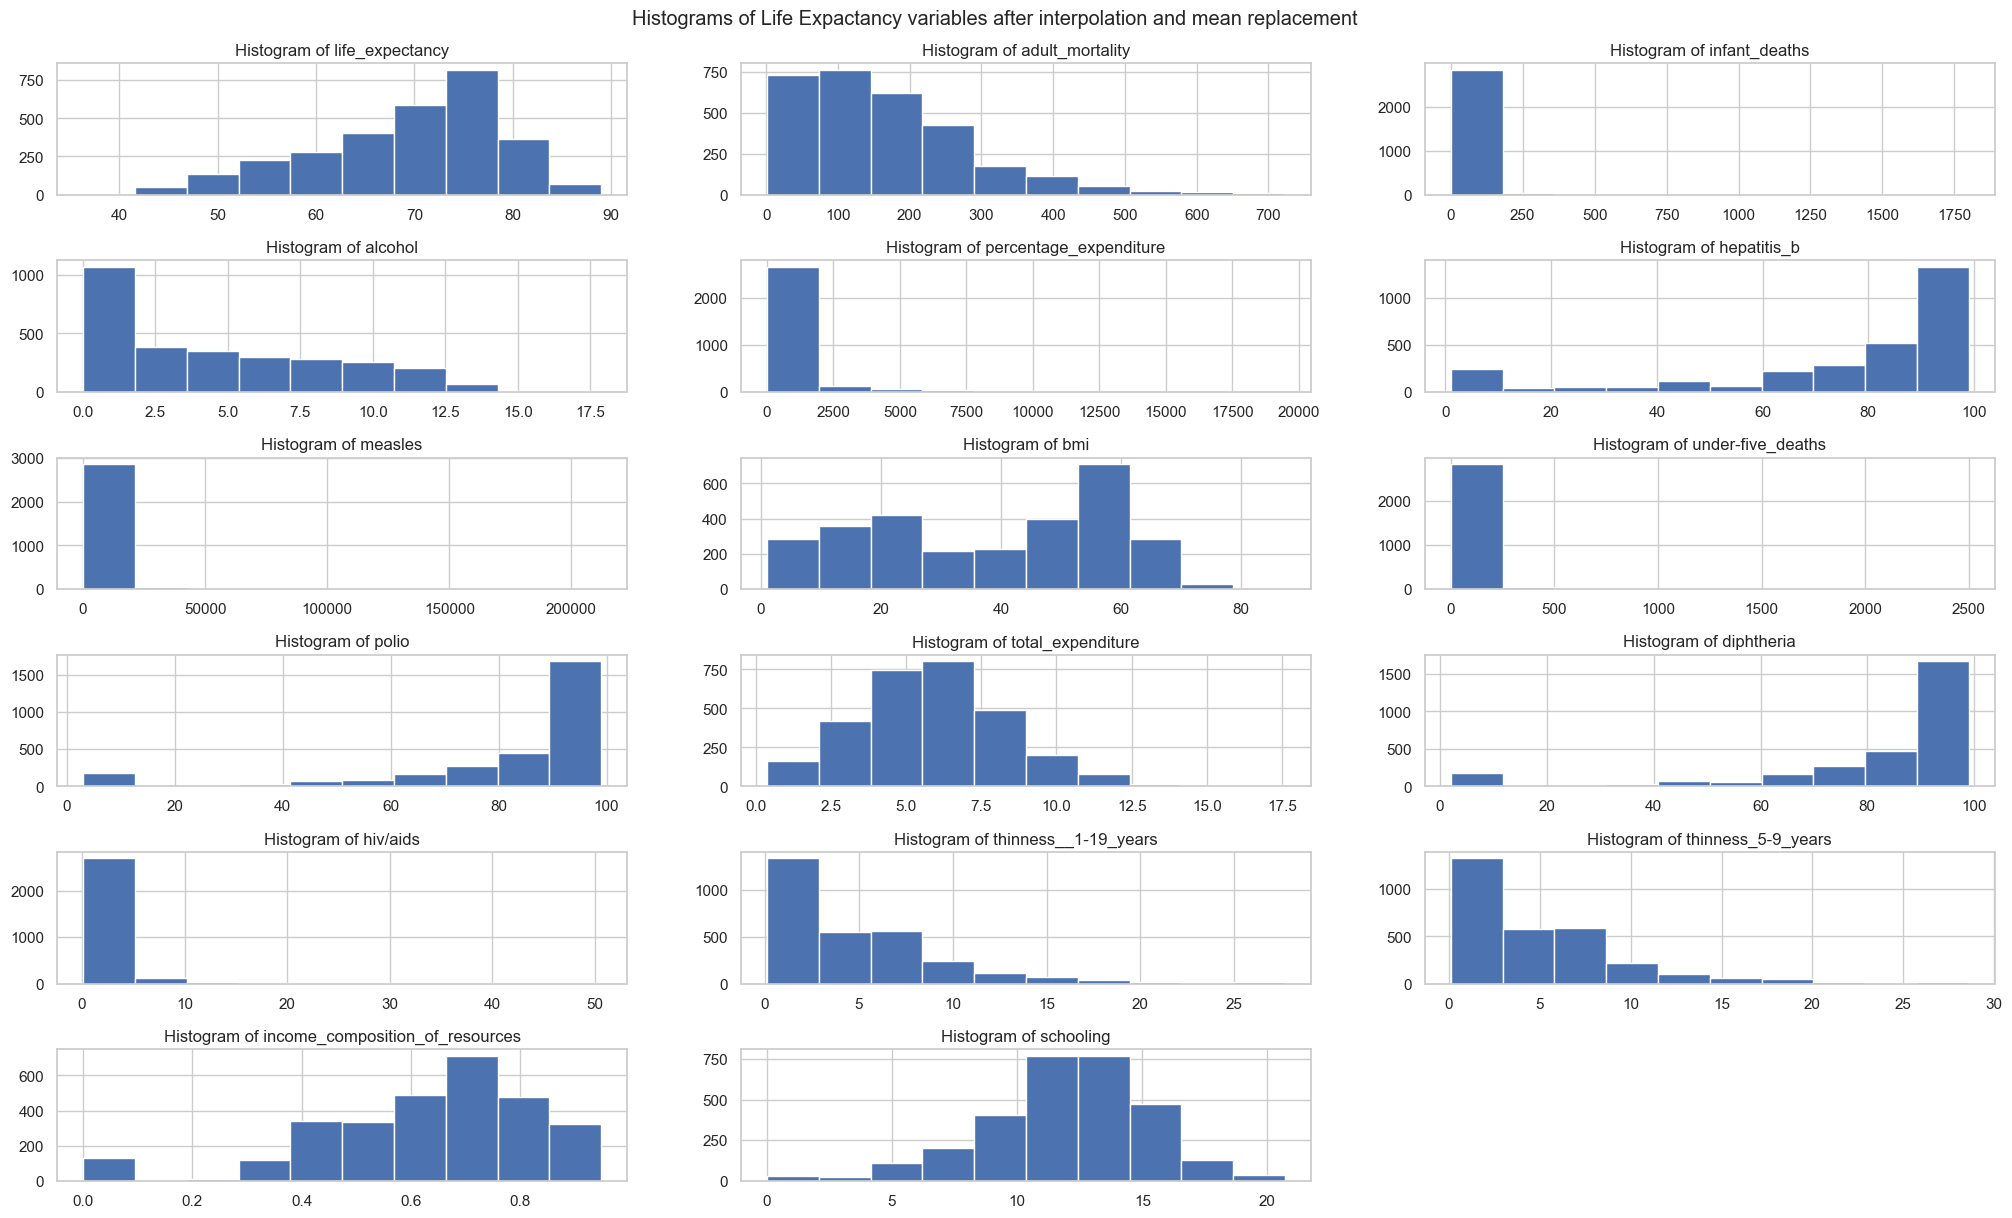

In [17]:
# Run the Null Report one more time
display(null_report(life_expectancy_df))

# Take a look at the variable distributions after all the nulls have been replaced
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_df.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.hist(life_expectancy_df[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables after interpolation and mean replacement")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show()

### Outlier Detection
_Z-Score_: To calculate Z-score, first, scale the variable so that its mean is 0 and it's standard deviation is 1.  Then measure how far a value is away from the mean (0) in terms of standard deviations (1).  The bigger the Z-score value, the farther it is from the mean and the more likely it is an outlier.

_Turkey's Method (IQR Method)_: This method consideres all values that are outside the threshold of 1.5 times the Interquartile Range (IQR) as outliers.  You can also changes the threshold to other values.

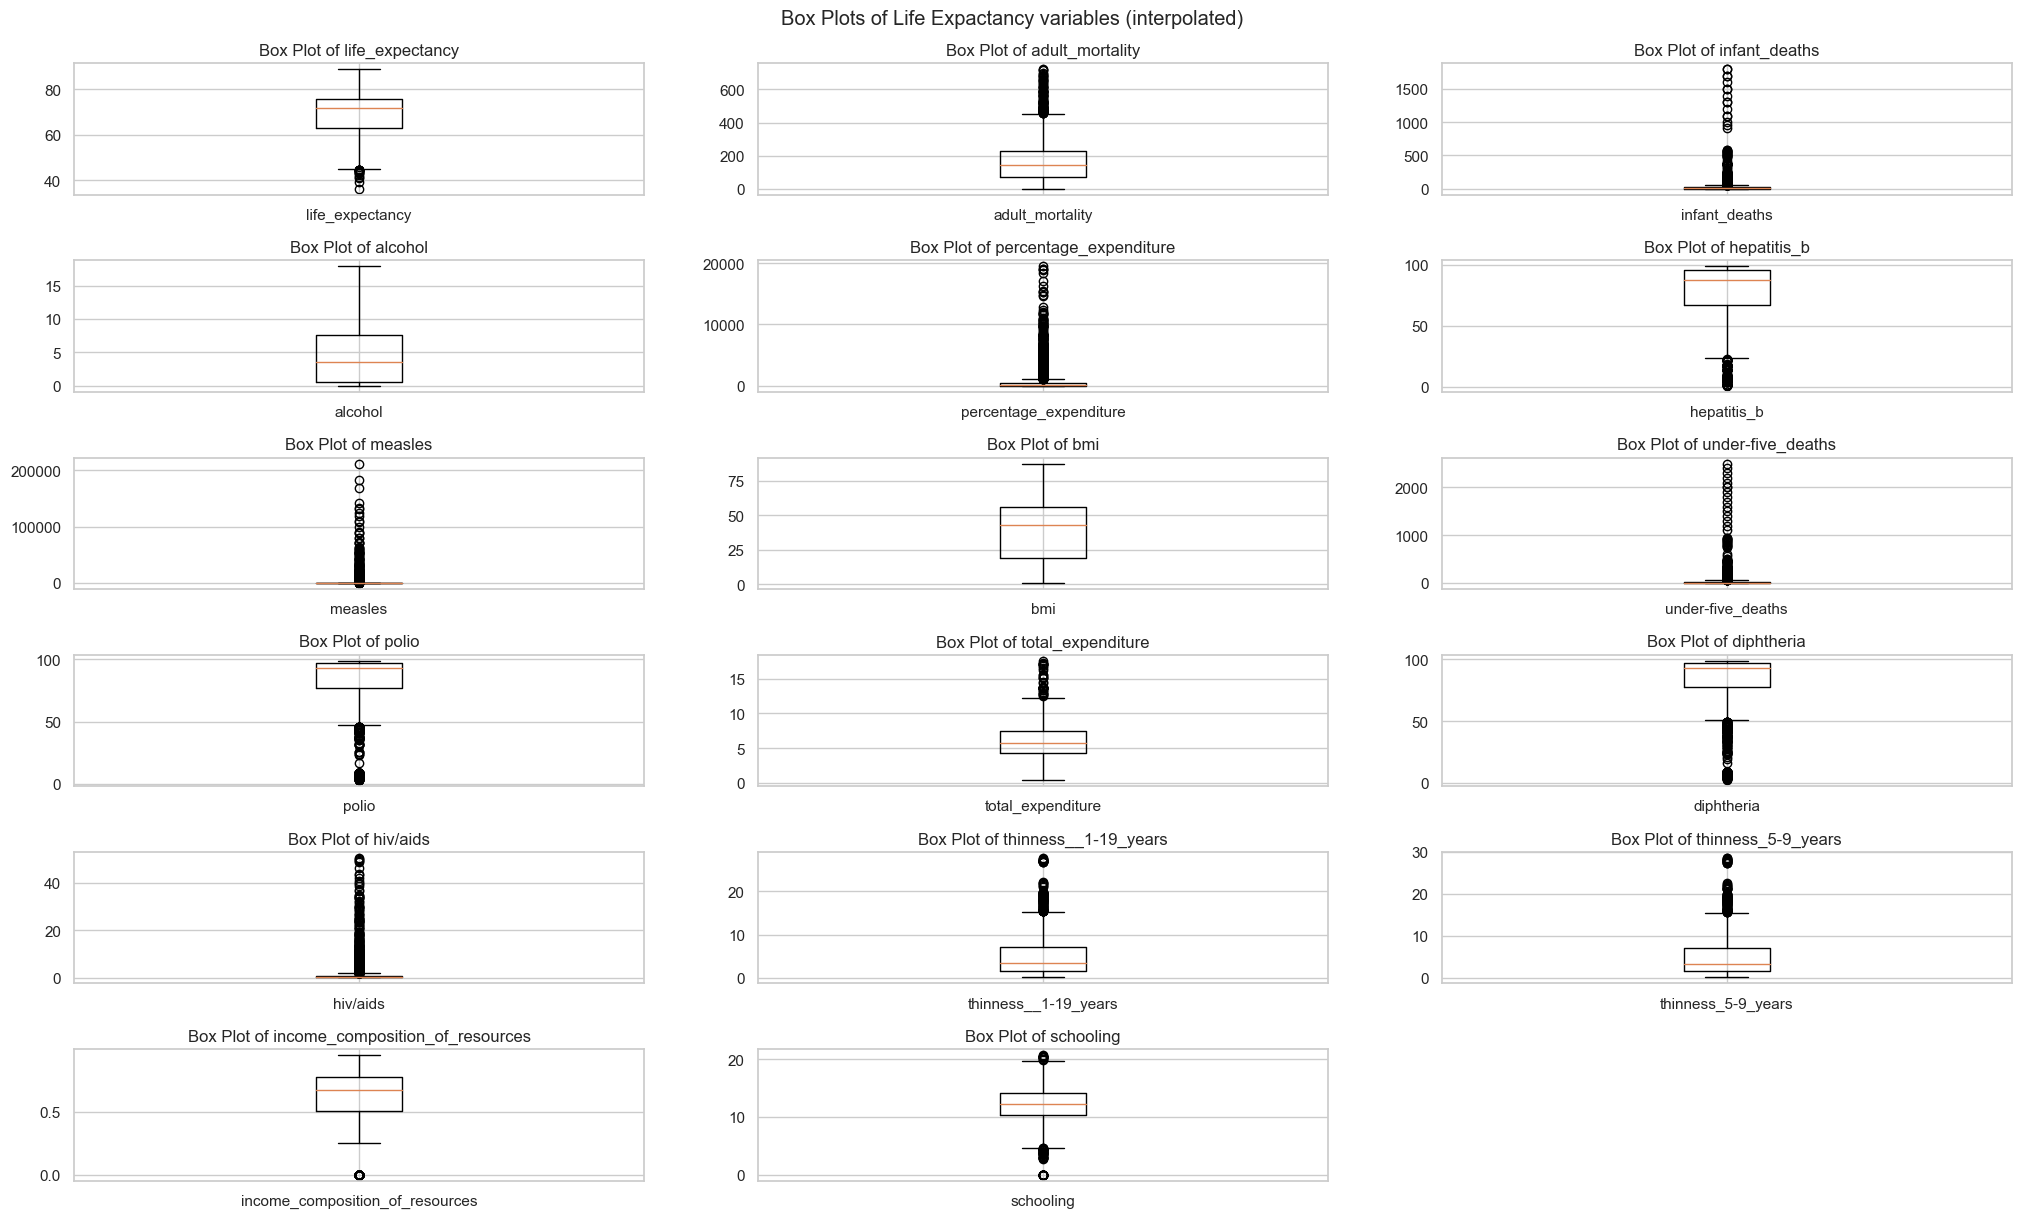

In [18]:
# Take an initial look at boxplots to get a feel for outliers in the data
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_df.columns[3:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_df[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (interpolated)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [20]:
# Use Z-Scores to establish a threshold for outliers
def run_z_score(df):
    continuous_cols = df.select_dtypes(exclude=['object','category','datetime64[ns]']).columns
    for col in continuous_cols:
        z_scores = zscore(df[col])
        print(f"Variable: {col}:")
        for threshold in range(1,5): 
            print(f"\tZ-Score threshold: {threshold} | Number of outliers is: ", 
                f"{len(np.where(z_scores > threshold)[0])}")
        print(100*"=")

# Run the run_z_score function 
run_z_score(life_expectancy_df)

Variable: life_expectancy:
	Z-Score threshold: 1 | Number of outliers is:  400
	Z-Score threshold: 2 | Number of outliers is:  11
	Z-Score threshold: 3 | Number of outliers is:  0
	Z-Score threshold: 4 | Number of outliers is:  0
Variable: adult_mortality:
	Z-Score threshold: 1 | Number of outliers is:  405
	Z-Score threshold: 2 | Number of outliers is:  139
	Z-Score threshold: 3 | Number of outliers is:  40
	Z-Score threshold: 4 | Number of outliers is:  11
Variable: infant_deaths:
	Z-Score threshold: 1 | Number of outliers is:  110
	Z-Score threshold: 2 | Number of outliers is:  56
	Z-Score threshold: 3 | Number of outliers is:  37
	Z-Score threshold: 4 | Number of outliers is:  29
Variable: alcohol:
	Z-Score threshold: 1 | Number of outliers is:  591
	Z-Score threshold: 2 | Number of outliers is:  77
	Z-Score threshold: 3 | Number of outliers is:  3
	Z-Score threshold: 4 | Number of outliers is:  0
Variable: percentage_expenditure:
	Z-Score threshold: 1 | Number of outliers is:  222

In [22]:
# Use the IQR Method to establish a threshold for outliers
def run_iqr_method(df):
    for col in continuous_cols: 
        q75, q25 = np.percentile(df[col], [75, 25])
        iqr = q75 - q25

        print(f"Variable: {col}")
        for threshold in np.arange(1,5,0.5): 
            min_val = q25 - (iqr*threshold)
            max_val = q75 + (iqr*threshold)
            outliers = len((np.where((df[col] > max_val) 
                        | (df[col] < min_val))[0]))
            print(f"\tIQR Threshold: {threshold:>{4}.1f} | Outliers: {outliers}")
        print(100*"=")

# Run Turkey's method function on life_expectancy_df
run_iqr_method(life_expectancy_df)

Variable: life_expectancy
	IQR Threshold:  1.0 | Outliers: 148
	IQR Threshold:  1.5 | Outliers: 17
	IQR Threshold:  2.0 | Outliers: 1
	IQR Threshold:  2.5 | Outliers: 0
	IQR Threshold:  3.0 | Outliers: 0
	IQR Threshold:  3.5 | Outliers: 0
	IQR Threshold:  4.0 | Outliers: 0
	IQR Threshold:  4.5 | Outliers: 0
Variable: adult_mortality
	IQR Threshold:  1.0 | Outliers: 183
	IQR Threshold:  1.5 | Outliers: 86
	IQR Threshold:  2.0 | Outliers: 41
	IQR Threshold:  2.5 | Outliers: 22
	IQR Threshold:  3.0 | Outliers: 5
	IQR Threshold:  3.5 | Outliers: 0
	IQR Threshold:  4.0 | Outliers: 0
	IQR Threshold:  4.5 | Outliers: 0
Variable: infant_deaths
	IQR Threshold:  1.0 | Outliers: 419
	IQR Threshold:  1.5 | Outliers: 315
	IQR Threshold:  2.0 | Outliers: 226
	IQR Threshold:  2.5 | Outliers: 187
	IQR Threshold:  3.0 | Outliers: 158
	IQR Threshold:  3.5 | Outliers: 138
	IQR Threshold:  4.0 | Outliers: 130
	IQR Threshold:  4.5 | Outliers: 121
Variable: alcohol
	IQR Threshold:  1.0 | Outliers: 15
	IQR T

In [38]:
# Take a look at what effect winsorization has on the variables
life_expectancy_winsorized = life_expectancy_df.copy()

for col in continuous_cols: 
    life_expectancy_winsorized[f"{col}_winsorized"] = winsorize(life_expectancy_winsorized[col], (0.2,0.2))

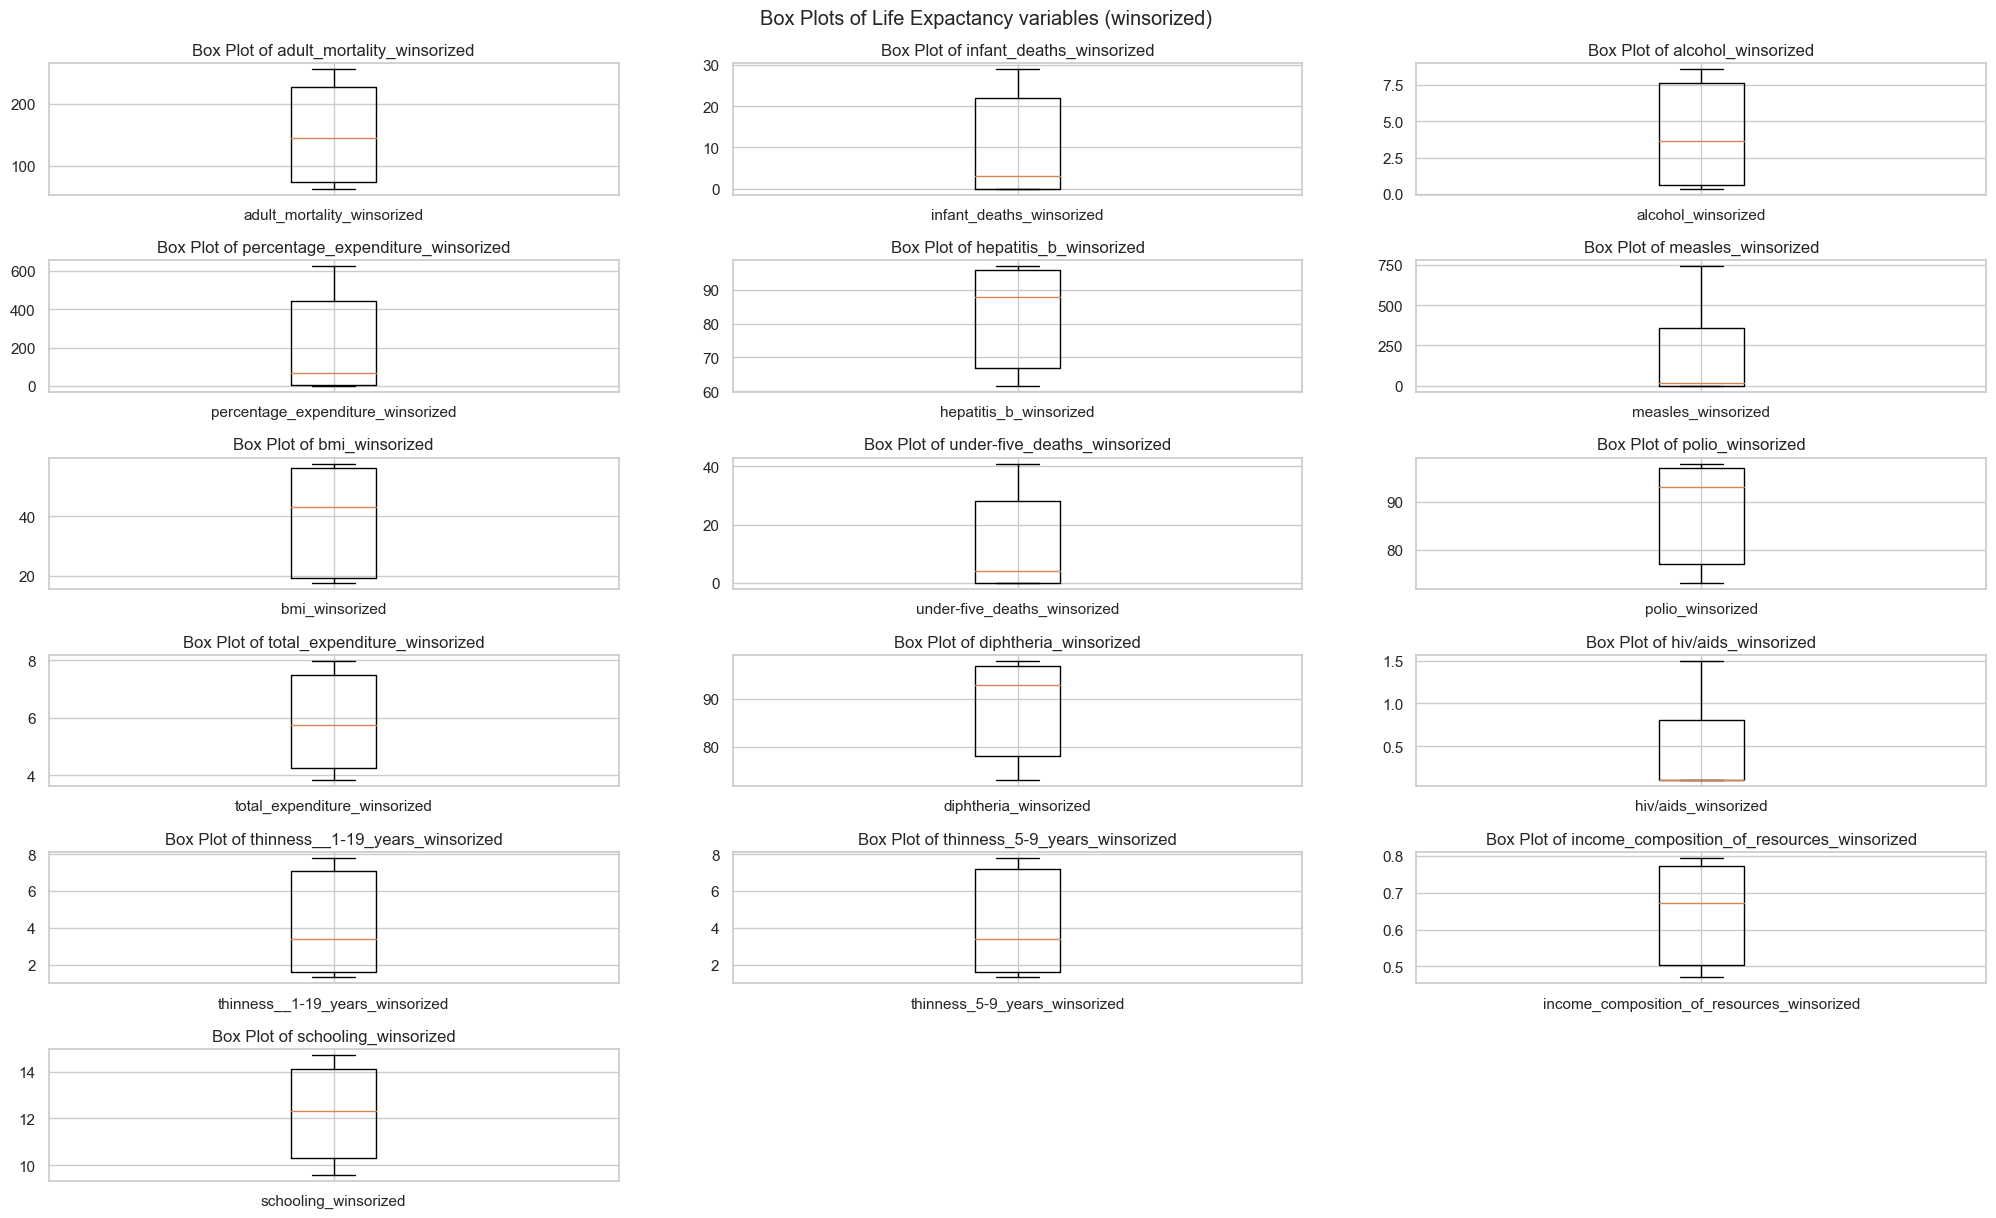

In [39]:
# Take an initial look at boxplots to get a feel for outliers in the winsorized data
""" 
    Apply two-way winsorization to the highest and lowest ends of the value distribution.  Set the values of the outliers to the value of the 80th percentile.
"""
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_winsorized.columns[21:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_winsorized[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (winsorized)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

In [41]:
# Take a look at what effect log transformation has on the variables
life_expectancy_log = life_expectancy_df.copy()

for col in continuous_cols: 
    life_expectancy_log[f"{col}_log"] = np.log(life_expectancy_log[col])

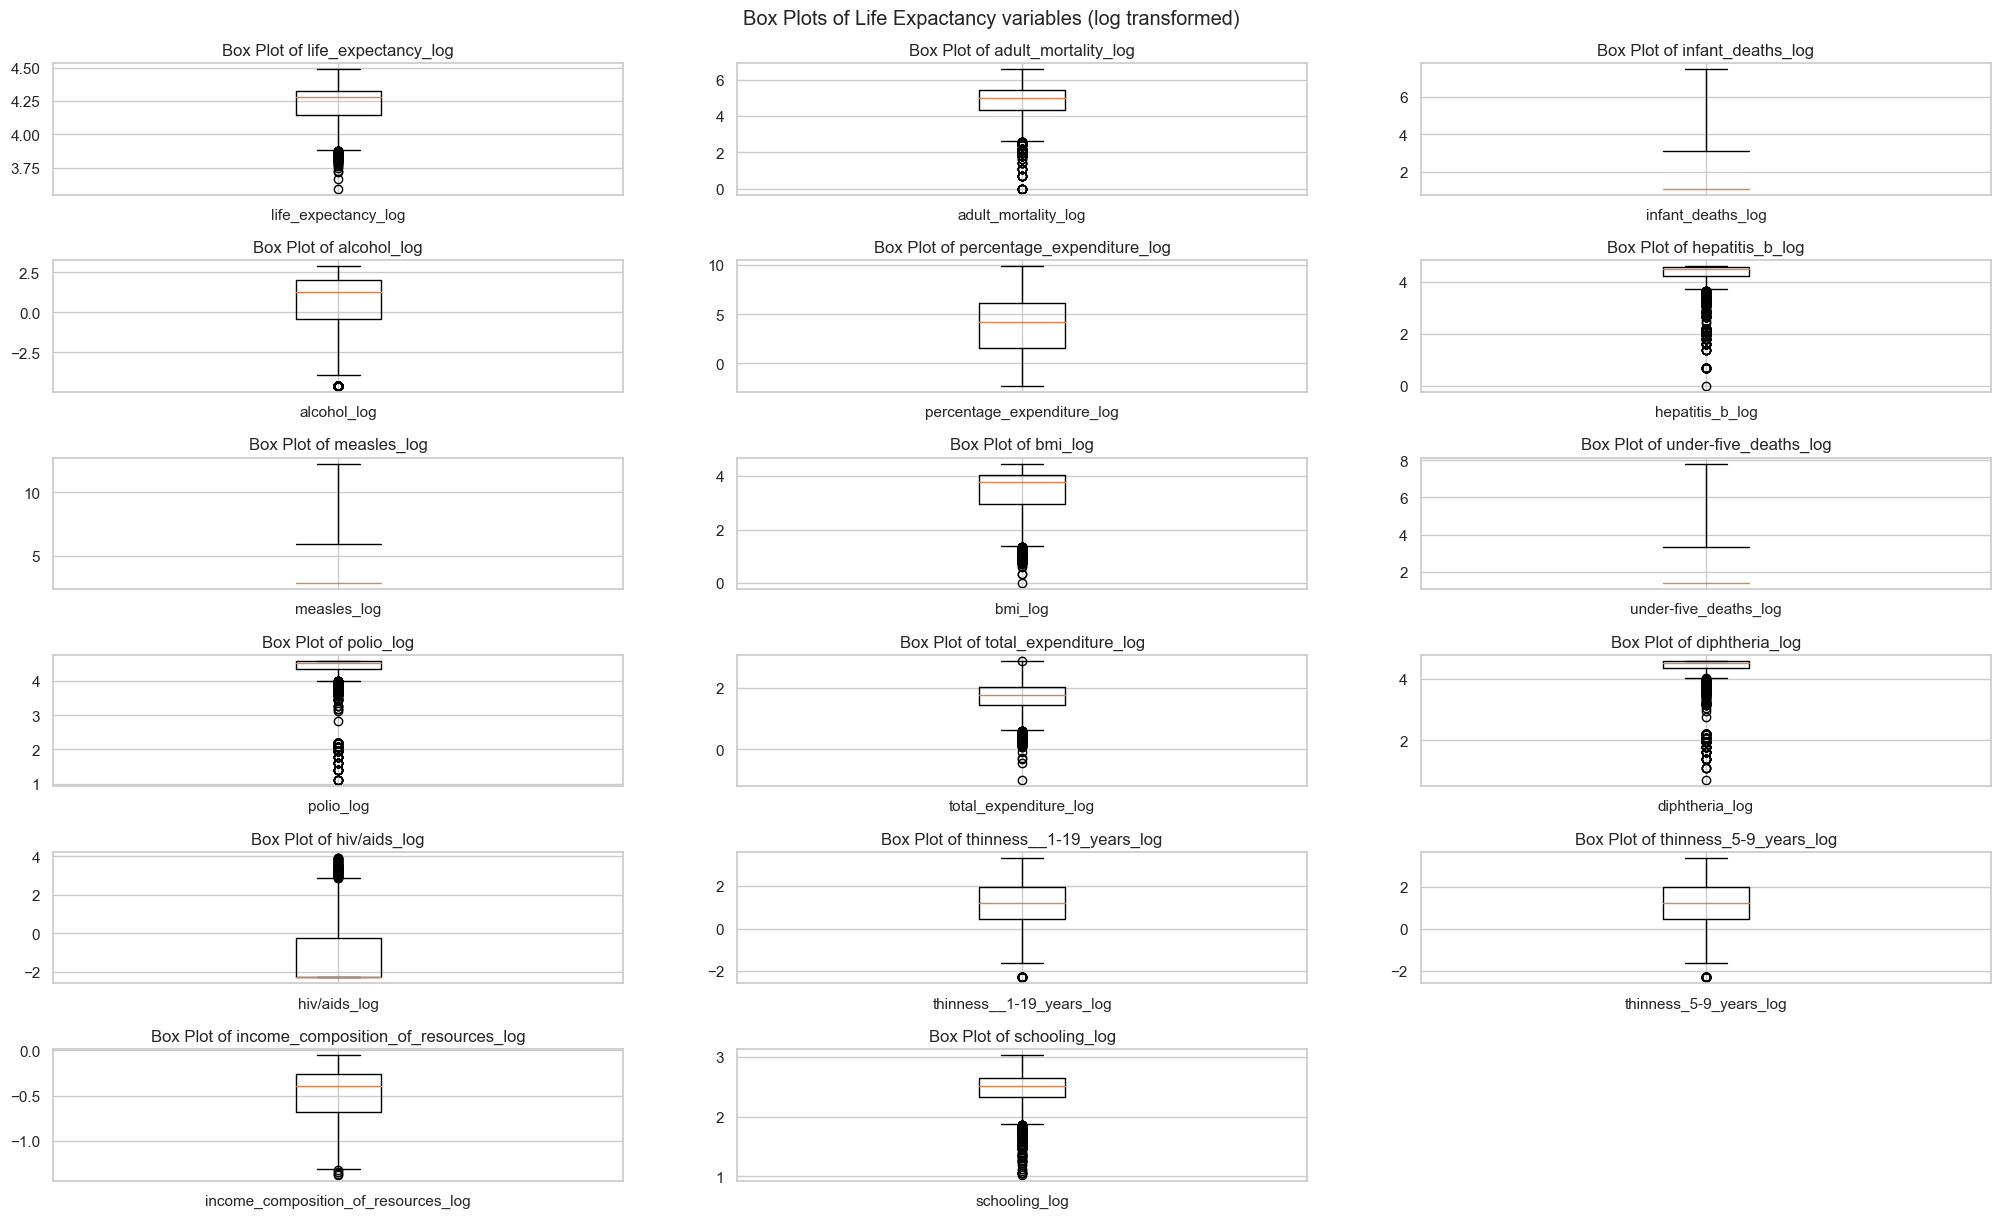

In [42]:
# Take an initial look at boxplots to get a feel for outliers in the log transformed data
plt.figure(figsize=(25,18))

i = 0
for col in life_expectancy_log.columns[20:]:
    i += 1
    plt.subplot(8,3,i)
    plt.boxplot(life_expectancy_log[col])
    plt.xticks([1], [col])
    plt.title(f"Box Plot of {col}")

plt.suptitle("Box Plots of Life Expactancy variables (log transformed)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

### Bullet Two: Dealing with Nulls and outliers

#### _Nulls_
The Life Expectancy data covers the timeframe from 2000 to 2015, since it is timeseries data, interpolation seems to be the best fit for filling in missing informaiton.  I first grouped the data by country first, so that when interpolaiton is applied nulls are replaced with sensible values.  I had Pandas fill nulls both forward and backward when applying interpolation.  This did not remove all nulls from the data.  This stemms from the grouping mentioned earlier.  Not all of the countries report variable data for the lifetime of the data set and therefore there is no informaiton for Pandas to used as source data.  For the remaining null values I elected to drop the null rows.

#### _Outliers_
Generally, outliers have several undesirable effects on data being examined.  One, they can skew statistical measures like the mean which can lead to misrepresentations of the relationships in the data being examined.  Two, outliers can negatively impact machine learning models, which can be sensitive to extreme values. With regard to the Life Expectancy data, winsorization provides much better coverage for outliers over a log transformation.

## Univariate analysis

In [52]:
# display(life_expectancy_winsorized.describe())
life_expectancy_winsorized.describe(include='all')

country                 year      status  life_expectancy  \
count       2938                 2938        2938      2938.000000   
unique       193                   16           2              NaN   
top     Zimbabwe  2013-01-01 00:00:00  Developing              NaN   
freq          16                  193        2426              NaN   
first        NaN  2000-01-01 00:00:00         NaN              NaN   
last         NaN  2015-01-01 00:00:00         NaN              NaN   
mean         NaN                  NaN         NaN        69.231777   
std          NaN                  NaN         NaN         9.508362   
min          NaN                  NaN         NaN        36.300000   
25%          NaN                  NaN         NaN        63.200000   
50%          NaN                  NaN         NaN        72.000000   
75%          NaN                  NaN         NaN        75.600000   
max          NaN                  NaN         NaN        89.000000   

        adult_mortality  infant_deaths      alcohol  percentage_expenditure  \
count       2938.000000    2938.000000  2938.000000             2938.000000   
unique              NaN            NaN          NaN                     NaN   
top                 NaN            NaN          NaN                     NaN   
freq                NaN            NaN          NaN                     NaN   
first               NaN            NaN          NaN                     NaN   
last                NaN            NaN          NaN                     NaN   
mean         164.741882      30.303948     4.518139              738.251295   
std          124.083816     117.926501     4.058862             1987.914858   
min            1.000000       0.000000     0.010000                0.000000   
25%           74.000000       0.000000     0.642500                4.685343   
50%          144.000000       3.000000     3.635000               64.912906   
75%          227.000000      22.000000     7.600000              441.534144   
max          723.000000    1800.000000    17.870000            19479.911610   

        hepatitis_b        measles  ...  bmi_winsorized  \
count   2938.000000    2938.000000  ...     2938.000000   
unique          NaN            NaN  ...             NaN   
top             NaN            NaN  ...             NaN   
freq            NaN            NaN  ...             NaN   
first           NaN            NaN  ...             NaN   
last            NaN            NaN  ...             NaN   
mean      75.832054    2419.592240  ...       38.821228   
std       27.928179   11467.272489  ...       16.444031   
min        1.000000       0.000000  ...       17.600000   
25%       67.000000       0.000000  ...       19.400000   
50%       88.000000      17.000000  ...       43.000000   
75%       96.000000     360.250000  ...       56.100000   
max       99.000000  212183.000000  ...       57.600000   

        under-five_deaths_winsorized  polio_winsorized  \
count                    2938.000000       2938.000000   
unique                           NaN               NaN   
top                              NaN               NaN   
freq                             NaN               NaN   
first                            NaN               NaN   
last                             NaN               NaN   
mean                       13.277740         88.249489   
std                        16.412181          9.801401   
min                         0.000000         73.000000   
25%                         0.000000         77.000000   
50%                         4.000000         93.000000   
75%                        28.000000         97.000000   
max                        41.000000         98.000000   

        total_expenditure_winsorized  diphtheria_winsorized  \
count                    2938.000000            2938.000000   
unique                           NaN                    NaN   
top                              NaN                    NaN   
freq                         

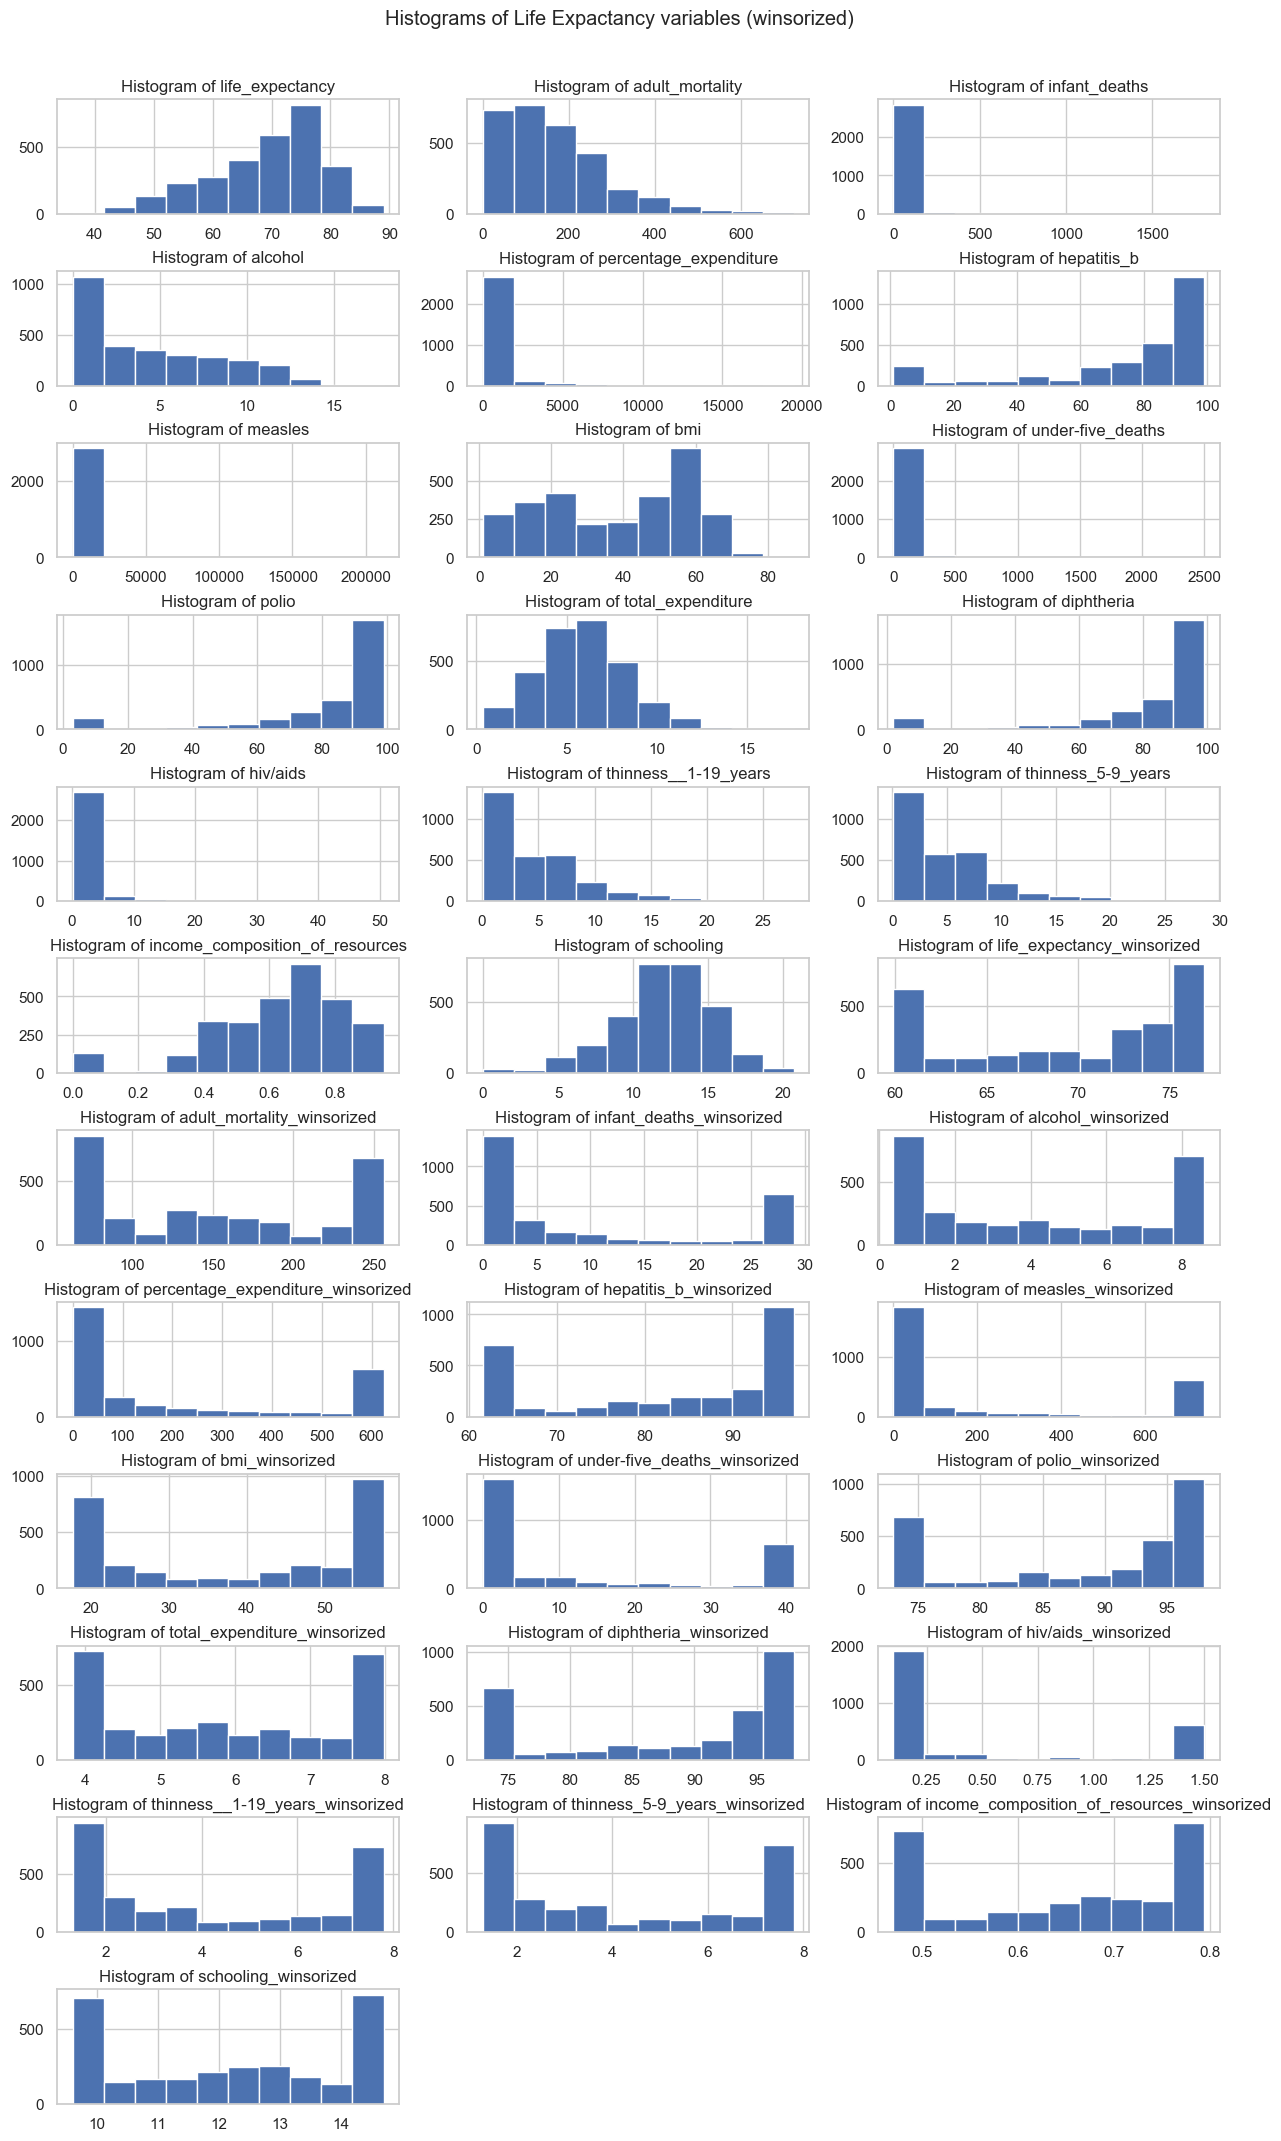

In [56]:
# Take a look at the variable distributions after winsorization focus on the winsorized variables
plt.figure(figsize=(15,30))

i = 0
for col in life_expectancy_winsorized.columns[3:]:
    i += 1
    plt.subplot(15,3,i)
    plt.hist(life_expectancy_winsorized[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables (winsorized)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

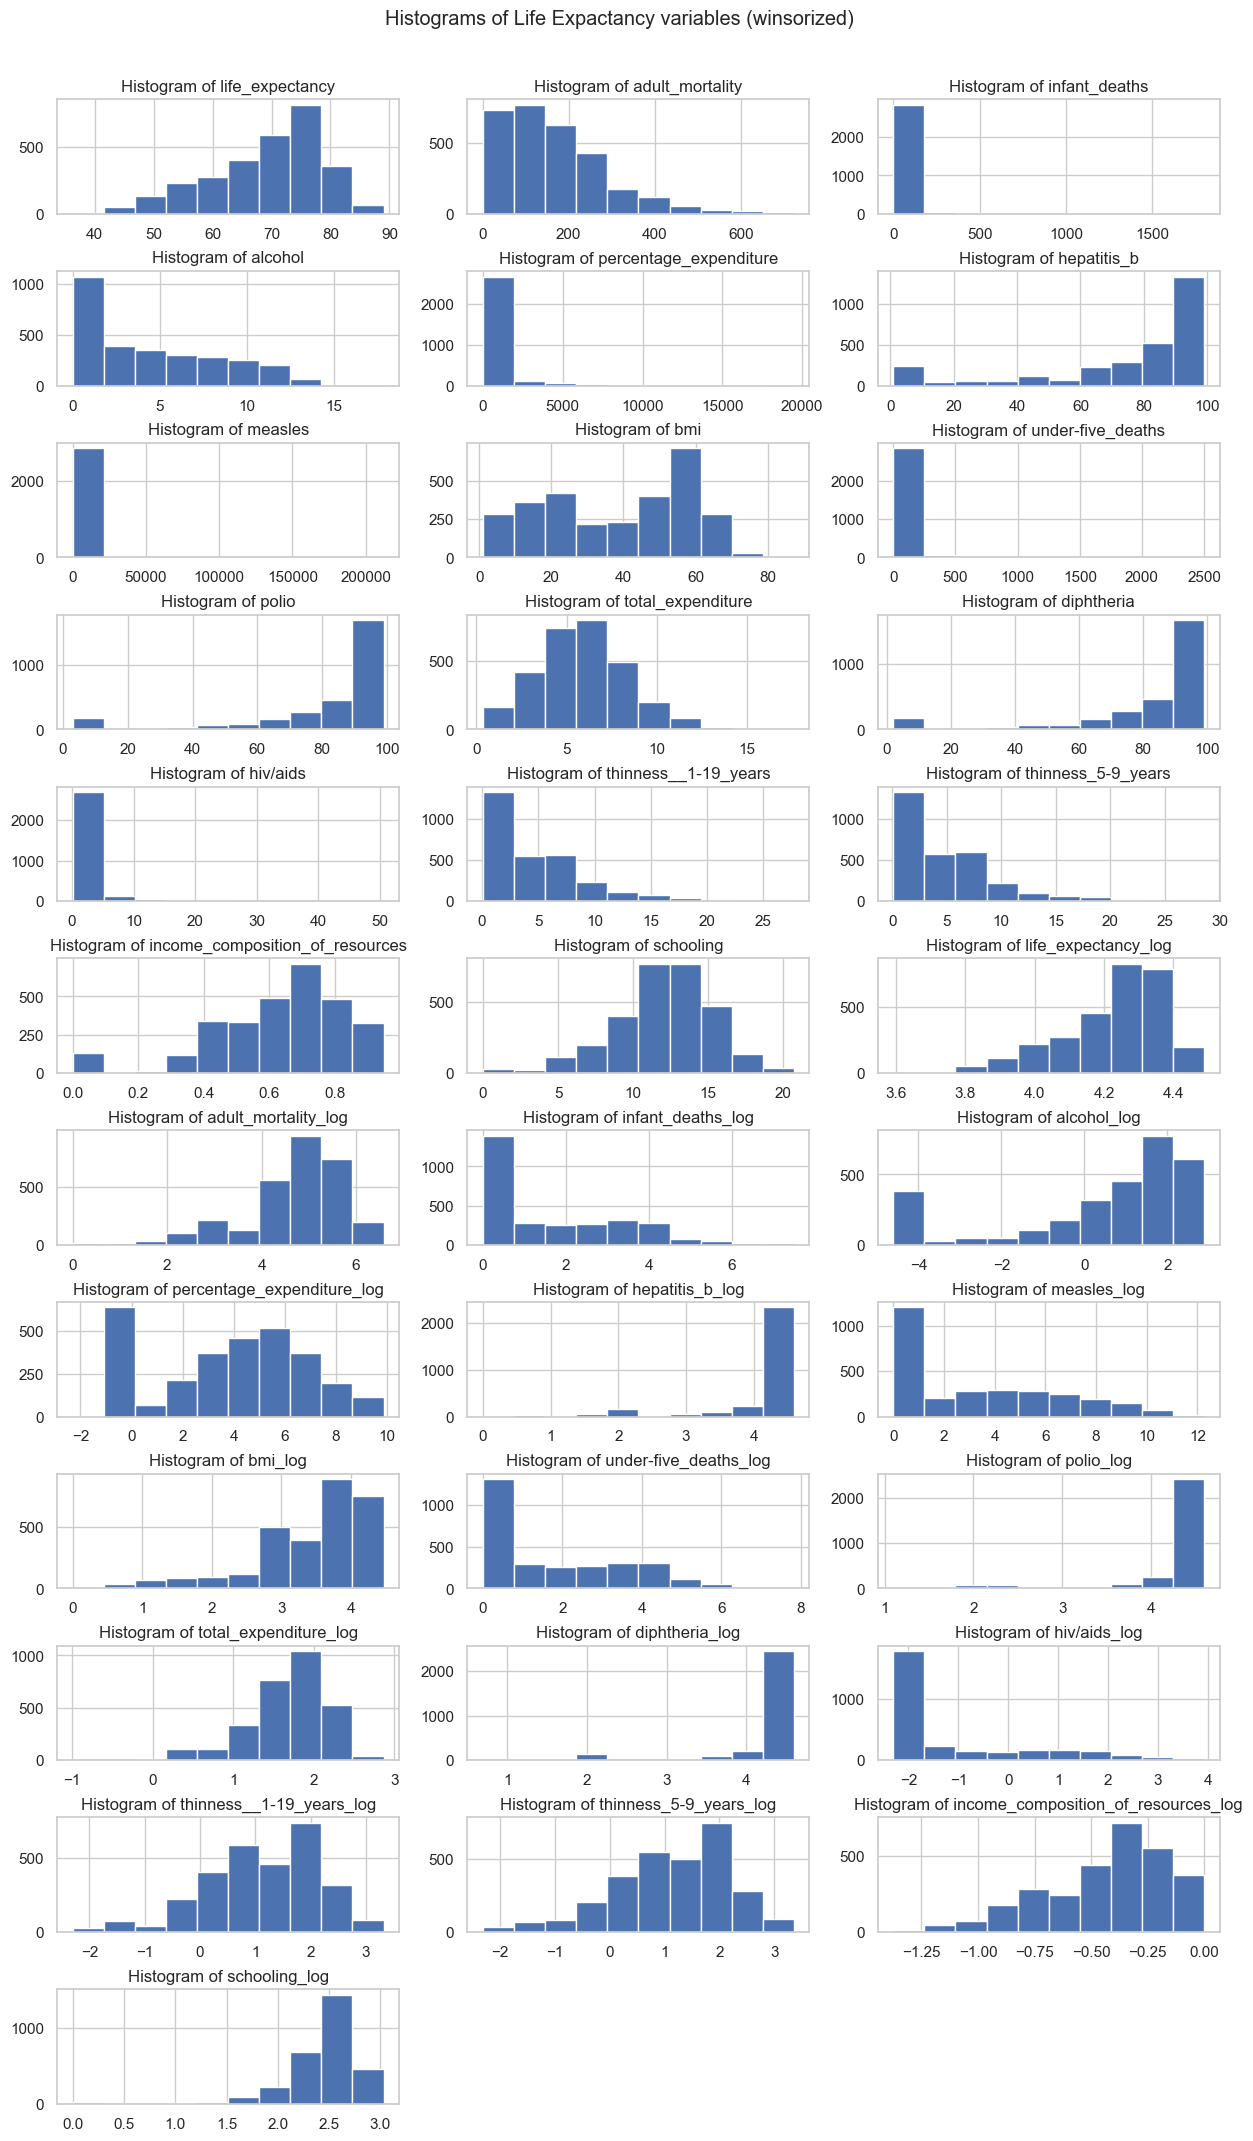

In [61]:
# Take a look at the variable distributions after winsorization focus on the winsorized variables
plt.figure(figsize=(15,30))

i = 0
for col in life_expectancy_log.columns[3:]:
    i += 1
    life_expectancy_log[col] = life_expectancy_log[col].apply(lambda x: x if np.isfinite(x) else 0)
    plt.subplot(15,3,i)
    plt.hist(life_expectancy_log[col])
    plt.title(f"Histogram of {col}")

plt.suptitle("Histograms of Life Expactancy variables (winsorized)")
plt.subplots_adjust(hspace=0.5, top=0.95)
plt.show();

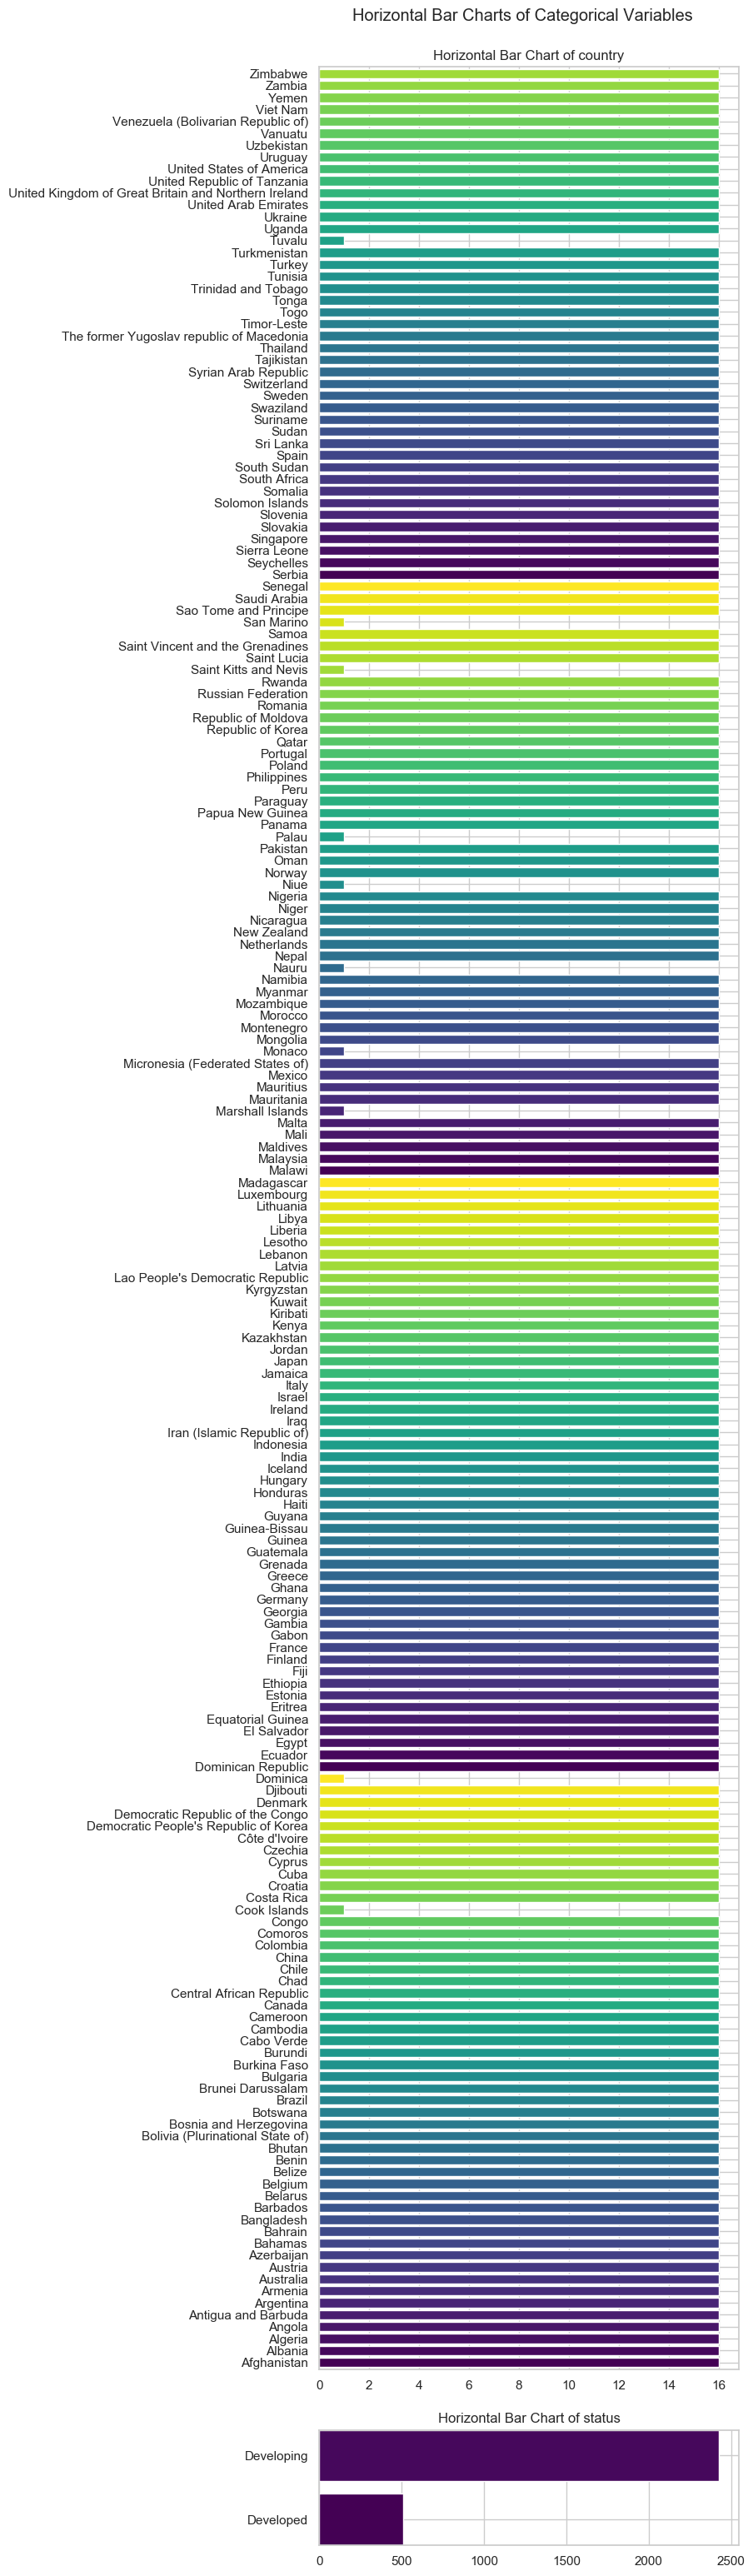

In [180]:
# Barchart of categorical variables
rows = len(life_expectancy_log.select_dtypes(include="category").columns)

fig = plt.figure(figsize=(6.5,35))

spec = gridspec.GridSpec(ncols=1, nrows=rows, height_ratios=[20,1], figure=fig)
# my_colors = [(x/10.0, x/20.0, 0.75) for x in range(len(life_expectancy_log))]
# my_colors = [x/10 for x in range(len(life_expectancy_log))]
viridis = cm.get_cmap('viridis', 50)
# my_colors = list(islice(cycle(accent), None, len(life_expectancy_log)))


i=0
for col in life_expectancy_log.select_dtypes(include="category").columns:    
    fig.add_subplot(spec[i,0])
    plt.barh(
        life_expectancy_log.groupby(col)[col].count().index, 
        life_expectancy_log.groupby(col)[col].count(), 
        color=viridis.colors
    )
    plt.margins(0.05,0.001)
    plt.title(f"Horizontal Bar Chart of {col}")

    i+=1

plt.suptitle("Horizontal Bar Charts of Categorical Variables")
plt.subplots_adjust(hspace=0.05, top=.96)
plt.show();

In [67]:
len(life_expectancy_log.select_dtypes(include="category").columns)

2

In [170]:
my_colors(0.56)

(0.2196078431372549, 0.4235294117647059, 0.6901960784313725, 1.0)

In [176]:
viridis.colors

array([[0.267004, 0.004874, 0.329415, 1.      ],
       [0.283072, 0.130895, 0.449241, 1.      ],
       [0.262138, 0.242286, 0.520837, 1.      ],
       [0.220057, 0.343307, 0.549413, 1.      ],
       [0.177423, 0.437527, 0.557565, 1.      ],
       [0.143343, 0.522773, 0.556295, 1.      ],
       [0.119512, 0.607464, 0.540218, 1.      ],
       [0.166383, 0.690856, 0.496502, 1.      ],
       [0.319809, 0.770914, 0.411152, 1.      ],
       [0.525776, 0.833491, 0.288127, 1.      ],
       [0.762373, 0.876424, 0.137064, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])